# Machine Learning HW2

## Read Training Set

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train_file = 'data/X_train'
label_file = 'data/Y_train'
test_file = 'data/X_test'

with open(train_file, 'r') as f:
    next(f) # 跳过首行表头
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
with open(label_file, 'r') as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype = float)
with open(test_file, 'r') as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)

### Useful Function

数据集标准化 & 打乱数据集 & 划分验证集

In [3]:
def normalize(X):
    # This function normalize specific colunms of X
    # 
    # Arguments:
    #     X: data to be processed
    # Outputs:
    #     X: nomarlized data
    #     X_mean: computed mean value of training data
    #     X_std: computed standard deviation of training data

    X_mean = np.mean(X, axis = 0)
    X_std = np.std(X, axis = 0)
    for i in range(len(X)):
        for j in range(len(X[i])):
            if X_std[j]:
                X[i][j] = (X[i][j] - X_mean[j]) / X_std[j]
    return X,X_mean,X_std

def shuffle(X, Y):
    # This function shuffles two equal-length list/array, X and Y, together.
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return X[randomize], Y[randomize]

def train_dev_divide(X, Y, div_ratio = 0.2):
    # This function normalize specific colunms of X
    train_size = int(len(X) * (1 - div_ratio))
    return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]

### Data preprocessing

In [9]:
X, Y = shuffle(X_train, Y_train)
X, _, _ = normalize(X)
train_X, train_y, val_X, val_y = train_dev_divide(X, Y)

In [10]:
train_size = train_X.shape[0]
val_size = val_X.shape[0]
params_size = train_X.shape[1]
data_size = X.shape[0]
print('The data is :',data_size)
print('The data use for train is :',train_size)
print('The data use for val is :',val_size)
print('The dim of feature is :',params_size)

The data is : 54256
The data use for train is : 43404
The data use for val is : 10852
The dim of feature is : 510


## Training
**Logistic Regression & Adam**

### Sigmoid function

In [6]:
def sigmoid_func(z):
    # Sigmoid function can be used to calculate probability.
    # To avoid overflow, minimum/maximum output value is set. 
    # Do not min-max, the inf may be in result  
    return np.clip(1 / (1 + np.exp(-z)), 1e-8, 1-(1e-8))

def forward(X,w):
    # The forward pass function to calculte the predicted y
    return sigmoid_func(X * w)


def accuracy(y_pred,y_label):
    # Accuracy function can be used to calaculate accuracy.
    # The result of the function is float.
    acc = 1 - np.mean(np.abs(y_pred - y_label))
    return acc

def cost_function(X, y, w):
    # Cost function can be used to calculate cost of the batch.
    # The result of the function is the mean of the batch.
    size = len(X)
    J1 = np.multiply(y, np.log(sigmoid_func(X * w)))
    J2 = np.multiply(1-y, np.log(1 - sigmoid_func(X * w)))
    cost = -np.sum(J1 + J2)
    return cost 

### Adam

In [12]:
params = int(params_size+1)

w = np.matrix(np.zeros([params,1]))
train_X = np.matrix(np.concatenate((np.ones([data_size,1]), X), axis = 1).astype(float))
train_Y = np.matrix(Y.reshape(-1,1))

X_val = np.matrix(np.concatenate((np.ones([val_size,1]), val_X), axis = 1).astype(float))
y_val = val_y.reshape(-1,1)
y_val = np.matrix(y_val)

# Initialize the parameters of the training
iteration = 1000
learning_rate = 0.0001
batch_size = 128
loss = 0
train_loss = []
val_loss = []
acc_list = []
p = 0.01

# Initialize the parameters of the adam
p_1 = 0.9
p_2 = 0.999
eps = 1e-8
s = np.matrix(np.zeros([params,1]))
r = np.matrix(np.zeros([params,1]))

for i in range(iteration):
    # Mini Batch
    for idx in range(int(data_size / batch_size)):
        batch_x = train_X[idx * batch_size: (idx+1)*batch_size,:]
        batch_y = train_Y[idx * batch_size: (idx+1)*batch_size,:]
        #Adam
        gradient = (batch_x.T * (sigmoid_func(batch_x * w) - batch_y))/ batch_size + p * w
        s = p_1 * s + (1 - p_1) * gradient
        r = p_2 * r + (1 - p_2) * np.power(gradient, 2)
        s_gradient = s / (1 - p_1)
        r_gradient = r / (1 - p_2)        
        w = w - np.multiply(learning_rate / (np.sqrt(r_gradient) + eps), s_gradient)

    loss = cost_function(train_X, train_Y, w)
    train_loss.append(loss / data_size)
    
    loss = cost_function(X_val, y_val, w)
    val_loss.append(loss / val_size)
    y_pred = np.round(forward(X_val, w))
    acc = accuracy(y_pred, y_val)
    acc_list.append(acc)
    


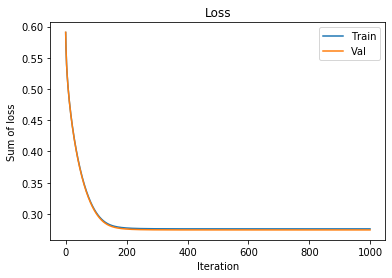

In [13]:
# Loss curve
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['Train','Val'])
plt.xlabel('Iteration')
plt.ylabel('Sum of loss')
plt.title('Loss')
plt.show()

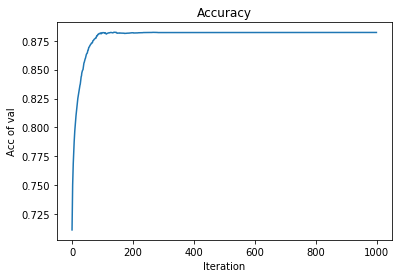

In [14]:
plt.plot(acc_list)
plt.title('Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Acc of val')
plt.show()

In [17]:
test_size = X_test.shape[0]
test_x,_,_ = normalize(X_test)
test_data = np.matrix(np.concatenate((np.ones([test_size,1]), test_x), axis = 1).astype(float))
print(test_size)
test_pre = sigmoid_func(test_data * w)
out = np.round(test_pre).astype(np.int)
out = np.asarray(out)
out

27622


array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [18]:
with open('submission.csv','w') as f:
    f.write('id,label\n')
    for i, label in enumerate(out):
        f.write(f'{i},{label[0]}\n')

In [ ]:
/Users/Juyi/Desktop/Code/Machine-learns-me/Li_DL/HW_2/submission.csv